In [1]:
import nimblephysics as nimble
import numpy as np
import torch

import time

from IPython.core.display_functions import clear_output
from einops import einsum, repeat
from scipy.ndimage import median_filter
from tqdm import tqdm
import os
import pickle

In [2]:
trial_path = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/S1.b3d"
GEOMETRY_PATH = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/Geometry/"
GRAVITY = 9.80665

In [3]:
from typing import List, Tuple

subject = nimble.biomechanics.SubjectOnDisk(trial_path)
skeleton = nimble.dynamics.Skeleton = subject.readSkel(processingPass=1,
                                                       geometryFolder=GEOMETRY_PATH)

skel_joints = [skeleton.getJoint(i).getName() for i in range(skeleton.getNumJoints())]
skel_body_nodes = [skeleton.getBodyNode(i).getName() for i in range(skeleton.getNumBodyNodes())]

print(len(skel_body_nodes))
skel_body_nodes

24


['pelvis',
 'femur_r',
 'tibia_r',
 'talus_r',
 'calcn_r',
 'toes_r',
 'femur_l',
 'tibia_l',
 'talus_l',
 'calcn_l',
 'toes_l',
 'lumbar_body',
 'thorax',
 'head',
 'scapula_r',
 'humerus_r',
 'ulna_r',
 'radius_r',
 'hand_r',
 'scapula_l',
 'humerus_l',
 'ulna_l',
 'radius_l',
 'hand_l']

Setting len to 0.106608
Setting neutral pos to   0
0.7
  0
Setting len to 0.342794
Setting neutral pos to    0
-0.6
   0
Setting len to 0.119716
Setting neutral pos to   0
0.2
  0


In [4]:
print(len(skel_joints))
skel_joints

24


['ground_pelvis',
 'hip_r',
 'walker_knee_r',
 'ankle_r',
 'subtalar_r',
 'mtp_r',
 'hip_l',
 'walker_knee_l',
 'ankle_l',
 'subtalar_l',
 'mtp_l',
 'lumbar',
 'thoracic_spine',
 'neck',
 'scapulothoracic_r',
 'GlenoHumeral_r',
 'elbow_r',
 'radioulnar_r',
 'wrist_r',
 'scapulothoracic_l',
 'GlenoHumeral_l',
 'elbow_l',
 'radioulnar_l',
 'wrist_l']

In [5]:
skeleton.getNumDofs()

49

In [6]:
right_wrist: nimble.dynamics.Joint = skeleton.getBodyNode("hand_r")
translation: np.ndarray = np.array([0.0, 0.05, 0.0])
rotation: np.ndarray = np.eye(3)
watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

skeleton.setGravity(np.array([0.0, -GRAVITY, 0.0]))

print(skeleton.getBodyNode("hand_r").getWorldTransform())

[[ 0.8503932  -0.28173527  0.44436094  0.07124618]
 [ 0.26341593  0.95906446  0.10395866  0.88399438]
 [-0.4554596   0.02864602  0.88979546  0.18382312]
 [ 0.          0.          0.          1.        ]]


In [7]:
import matplotlib.pyplot as plt

def minimize(sequence):
    smooth_weight = 0.36
    regularization_weight = 0.1
    lr = 2
    iterations = 10000
    device = "cuda" if torch.cuda.is_available() else "cpu"

    orig_sequence = torch.from_numpy(sequence).to(device=device)
    output_sequence = orig_sequence.detach().clone().requires_grad_(True)

    optimizer = torch.optim.SGD([output_sequence], lr=lr)

    def loss():
        return smooth_weight * torch.square(output_sequence - orig_sequence).sum() + regularization_weight * torch.square(output_sequence).sum()

    for i in range(iterations):
        optimizer.zero_grad()
        loss_val = loss()
        loss_val.backward()
        optimizer.step()

    return output_sequence.detach().cpu().numpy()

In [8]:
def fill_nans(acc: torch.Tensor) -> torch.Tensor:
    # Reshape (T, N, C) -> (T, N*C) for simpler 1D column-wise interpolation
    T, N, C = acc.shape
    acc_2d = acc.reshape(T, N * C)

    # Move to CPU (if on GPU) for NumPy ops
    acc_np = acc_2d

    for col_idx in range(acc_np.shape[1]):
        col_data = acc_np[:, col_idx]
        # Find indices of valid and invalid entries
        valid_mask = ~np.isnan(col_data)
        if not np.any(valid_mask):
            # All NaNs; decide how to fill them (zero or remain NaN)
            # Here we choose to fill with zero for demonstration:
            col_data[:] = 0.0
            continue
        if np.all(valid_mask):
            # Already has no NaNs in this column
            continue

        valid_x = np.where(valid_mask)[0]
        valid_y = col_data[valid_mask]
        invalid_x = np.where(~valid_mask)[0]

        # Interpolate
        col_data[invalid_x] = np.interp(invalid_x, valid_x, valid_y)

    # Move back to original device
    acc_filled = acc_np.reshape(T, N, C)
    return acc_filled

In [9]:
with open("/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/DIP_orig/S1/01.pkl", "rb") as file:
    vals = pickle.load(file, encoding="latin1")["imu"]

vals[:, :, :3]

array([[[ 0.89995843, -0.15217061, -0.40855714],
        [ 0.98648638, -0.01189452,  0.16341096],
        [        nan,         nan,         nan],
        ...,
        [-0.14920152, -0.95913027,  0.240433  ],
        [ 0.97157289,  0.08987311,  0.21901815],
        [        nan,         nan,         nan]],

       [[ 0.90291665, -0.15042667, -0.402633  ],
        [ 0.98649444, -0.01166408,  0.16337893],
        [ 0.98324461,  0.00484152,  0.18222677],
        ...,
        [-0.14931078, -0.95916191,  0.2402389 ],
        [ 0.97160456,  0.08989438,  0.21886885],
        [ 0.94187588,  0.02695563,  0.33487791]],

       [[ 0.90710633, -0.14777461, -0.39410756],
        [ 0.98643782, -0.01152577,  0.1637302 ],
        [ 0.98329519,  0.00478607,  0.18195509],
        ...,
        [-0.14962804, -0.95967677,  0.23797469],
        [ 0.97161546,  0.09008362,  0.21874263],
        [ 0.94187571,  0.02695153,  0.33487874]],

       ...,

       [[ 0.91603171,  0.03686403,  0.39940824],
        [ 0

In [10]:
from scipy import signal
from scipy.ndimage import uniform_filter1d
from scipy.spatial.transform import Rotation

import torch


class DIP_Subject:
    def __init__(self, b3d_path):
        self.subject = nimble.biomechanics.SubjectOnDisk(b3d_path)
        self.skeleton = self.subject.readSkel(processingPass=1, geometryFolder=GEOMETRY_PATH)
        self.subject_num = int(b3d_path.split("/")[-1].split(".")[0][1:])
        self.synthetic_component_names = [
            "head",
            "sternum",
            "pelvis",
            "lshoulder",
            "rshoulder",
            "lupperarm",
            "rupperarm",
            "llowerarm",
            "rlowerarm",
            "lupperleg",
            "rupperleg",
            "llowerleg",
            "rlowerleg",
            "lhand",
            "rhand",
            "lfoot",
            "rfoot",
        ]

        # Corresponding bones to the sensors
        self.skel_names = [
            "head",
            "thorax",
            "pelvis",
            "scapula_l",
            "scapula_r",
            "humerus_l",
            "humerus_r",
            "ulna_l",
            "ulna_r",
            "femur_l",
            "femur_r",
            "tibia_l",
            "tibia_r",
            "hand_l",
            "hand_r",
            "calcn_l",
            "calcn_r"
        ]

        self.N_MEAS = len(self.skel_names) * 3

        self.imus = [(self.skeleton.getBodyNode(name), nimble.math.Isometry3.Identity()) for name in self.skel_names]

        self.corresponding_imu_path = os.path.join(os.path.dirname(b3d_path), f"DIP_orig/S{self.subject_num}")
        self.trial_map = {}
        self.joint_data_map = {}
        self.trial_imu_map = {}
        # self.skeleton.setGravity([0, -GRAVITY, 0])
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Processing DIP Subject {self.subject_num}")


        # Creating a map between a trial for some subject and the corresponding frame list
        for i in range(self.subject.getNumTrials()):
            key = self.subject.getTrialOriginalName(i).split("_")[0]
            curr_trial = self.subject.readFrames(trial=i,
                                                 startFrame=0,
                                                 numFramesToRead=self.subject.getTrialLength(i),
                                                 includeProcessingPasses=True)

            if key in self.trial_map:
                self.trial_map[key].extend(curr_trial)
            else:
                self.trial_map[key] = curr_trial

        # Define Butterworth filter parameters
        self.fs = 60  # Sampling frequency
        self.cutoff =  8  # Cutoff frequency
        self.b, self.a = signal.butter(10, self.cutoff / (self.fs / 2), btype='low')

        # Creating a map for joint state
        for key, frames in self.trial_map.items():
            joint_angles_raw = np.vstack([frame.processingPasses[0].pos for frame in frames]).T
            joint_vel_raw = np.vstack([frame.processingPasses[0].vel for frame in frames]).T
            joint_acc_raw = np.vstack([frame.processingPasses[0].acc for frame in frames]).T

            """
            self.joint_data_map[key] = {
                "joint_angles": signal.filtfilt(self.b, self.a, joint_angles_raw, axis=1),
                "joint_vel": signal.filtfilt(self.b, self.a, joint_vel_raw, axis=1),
                "joint_acc": signal.filtfilt(self.b, self.a, joint_acc_raw, axis=1),
            }
            """
            self.filter = (1, 8)
            self.joint_data_map[key] = {
                "joint_angles": joint_angles_raw,
                "joint_vel": uniform_filter1d(median_filter(joint_vel_raw, size=self.filter), size=20, axis=1),
                "joint_acc": uniform_filter1d(median_filter(joint_acc_raw, size=self.filter), size=20, axis=1),
            }


            with open(os.path.join(self.corresponding_imu_path, f"{key}.pkl"), "rb") as file:
                real_data = pickle.load(file, encoding="latin1")["imu"]
                acc = real_data[:, :, 9:12]
                acc = fill_nans(acc)

            self.num_trials = len(self.joint_data_map.keys())

            self.synthetic_transformations = {}
            self.gravity_translation = {}
            self.gravity_transformation = {}

            self.trial_imu_map[key] = {
                "acc": acc,
            }

        self.syn_imu = {}
        self.get_syn_imu_to_real_transformations()

        self.opt_trans = {}
        self.find_optimal_syn_transformations()

        gui = nimble.NimbleGUI()
        gui.serve(8080)

        transform_dict = self.opt_trans["03"]

        curr_imu_analysis = self.syn_imu["03"]["acc"]

        for dim in range(3):
            plt.figure(figsize=(20,8))
            plt.plot(np.arange(curr_imu_analysis.shape[0]), curr_imu_analysis[:, 0, dim], label=f"Dimension {dim+1}")

            plt.xlabel("Time Step")
            plt.ylabel(f"Acceleration (Dim {dim})")
            plt.title(f"Acceleration over Time (Dimension {dim + 1})")
            plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
            plt.grid(True)
            plt.show()

        for t in tqdm(range(self.joint_data_map["03"]["joint_angles"].shape[1])):
            skeleton.setPositions(self.joint_data_map["03"]["joint_angles"][:, t])

            # Shape: (Sequence Length) x (IMUs) x (Rows) x (Cols)
            body_node_in_world = transform_dict["world_to_body_node"]

            # Shape: (IMUs) x (Rows) x (Cols)
            imu_in_body_node = transform_dict["body_node_to_imu"]

            # Grab the heads
            body_node_in_world = body_node_in_world[t, 0, :, :]
            imu_in_body_node = imu_in_body_node[0, :, :]

            imu_in_world_frame = imu_in_body_node @ body_node_in_world

            #gui.nativeAPI().renderBasis(prefix="transform_basis" ,scale=1, pos=imu_in_world_frame[:-1, -1], euler=Rotation.from_matrix(imu_in_world_frame[:-1, :-1]).as_euler('xyz'))
            gui.nativeAPI().createBox(key="box", size=np.array([0.05,0.01,0.1]), pos=imu_in_world_frame[:-1, -1], euler=Rotation.from_matrix(imu_in_world_frame[:-1, :-1]).as_euler('zyx'), color=np.array([1, 0, 0, 1. ]))
            gui.nativeAPI().createBox(key="box_body_node", size=np.array([0.05,0.01,0.1]), pos=body_node_in_world[:-1, -1], euler=Rotation.from_matrix(body_node_in_world[:-1, :-1]).as_euler('zyx'), color=np.array([1, 0, 0, 1. ]))
            # gui.nativeAPI().renderBasis(pos=body_node_in_world[:-1, -1], euler=Rotation.from_matrix(body_node_in_world[:-1, :-1]).as_euler('xyz'))
            # gui.nativeAPI().renderBasis()
            # gui.nativeAPI().renderArrow(start_pos, (gravity_direction / 10), 0.01, 0.04)

            # print(gravity_direction)
            gui.nativeAPI().renderSkeleton(skeleton)
            time.sleep(1/60)


    # Get estimated homogenous transformations from synthetix to real imu
    def get_syn_imu_to_real_transformations(self):
        for trial_name, trial in self.joint_data_map.items():
            joint_angles = trial["joint_angles"]
            joint_vel = trial["joint_vel"]
            joint_acc = trial["joint_acc"]

            curr_syn_acc = np.empty((self.N_MEAS,  joint_angles.shape[1]))
            curr_syn_angular_vel = np.empty((self.N_MEAS,  joint_angles.shape[1]))

            for t in range(joint_angles.shape[1]):
                self.skeleton.setPositions(joint_angles[:, t])
                self.skeleton.setVelocities(joint_vel[:, t])
                self.skeleton.setAccelerations(joint_acc[:, t])

                curr_syn_acc[:, t] = self.skeleton.getAccelerometerReadings(self.imus)
                curr_syn_angular_vel[:, t] = self.skeleton.getGyroReadings(self.imus)


            curr_syn_acc = curr_syn_acc.T.reshape(-1, 17, 3)
            curr_syn_angular_vel = curr_syn_angular_vel.T.reshape(-1, 17, 3)


            self.syn_imu[trial_name] = {"acc": curr_syn_acc, "angular_vel": curr_syn_angular_vel}

    def rotation_matrix(self, phi, theta, psi):
        """
        Generate a 3D rotation matrix given Euler angles (phi, theta, psi).
        """
        R_x_cos = np.cos(phi)
        R_x_sin = np.sin(phi)

        R_x = np.tile(np.eye(3)[np.newaxis, : , :], (17, 1, 1))
        R_x[:, 1, 1] = R_x_cos
        R_x[:, 2, 2] = R_x_cos
        R_x[:, 1, 2] = - R_x_sin
        R_x[:, 2, 1] = R_x_sin

        R_y_cos = np.cos(theta)
        R_y_sin = np.sin(theta)

        R_y = np.tile(np.eye(3)[np.newaxis, : , :], (17, 1, 1))
        R_y[:, 0, 0] = R_y_cos
        R_y[:, 2, 2] = R_y_cos
        R_y[:, 2, 0] = - R_y_sin
        R_y[:, 0, 2] = R_y_sin

        R_z_cos = np.cos(psi)
        R_z_sin = np.sin(psi)

        R_z = np.tile(np.eye(3)[np.newaxis, : , :], (17, 1, 1))
        R_z[:, 0, 0] = R_z_cos
        R_z[:, 1, 1] = R_z_cos
        R_z[:, 0, 1] = - R_z_sin
        R_z[:, 1, 0] = R_z_sin

        return R_z @ R_y @ R_x

    def get_transform(self, translation, rotation):
        ret = np.zeros((rotation.shape[0], 4, 4))

        ret[:, :3, :3] = rotation
        ret[:, :3, -1] = translation
        ret[:, 3, 3] = 1

        return ret

    def get_world_transforms(self, trial_name):
        num_time_steps = self.joint_data_map[trial_name]["joint_angles"].shape[1]
        world_transform = np.empty((num_time_steps, 17, 4, 4))


        for t in range(num_time_steps):
            self.skeleton.setPositions(self.joint_data_map[trial_name]["joint_angles"][:, t])

            for idx, body_node_name in enumerate(self.skel_names):
                world_transform[t, idx, :, :] = self.skeleton.getBodyNode(body_node_name).getWorldTransform().matrix()

        return world_transform

    def get_grads(self, loss, world_transforms, accs, phi, theta, psi):
        # This is a^T @ (homogenous world transform) for each time step for each imu
        rotated_accs = einsum(np.sign(loss), accs, world_transforms, "seq imu, seq imu r, seq imu r c -> seq imu c")
        # We can probably remove the repeat if we run into compute issues
        d_loss_d_imu_transform = repeat(rotated_accs, "seq imu c -> seq imu repeat c", repeat=4)

        d_loss_d_translation  = d_loss_d_imu_transform[:, :, :-1, -1]
        d_loss_d_rotation = d_loss_d_imu_transform[:, :, 0:-1, 0:-1]

        phi_cos = np.cos(phi)
        phi_sin = np.sin(phi)

        theta_cos = np.cos(theta)
        theta_sin = np.sin(theta)

        psi_cos = np.cos(psi)
        psi_sin = np.sin(psi)

        # Phi
        d_rotation_d_phi = np.empty((17, 3, 3))

        d_rotation_d_phi[:, 0, 0] = 0
        d_rotation_d_phi[:, 1, 0] = 0
        d_rotation_d_phi[:, 2, 0] = 0

        d_rotation_d_phi[:, 0, 1] = psi_cos * theta_sin * phi_cos + psi_sin * phi_sin
        d_rotation_d_phi[:, 1, 1] = psi_sin * theta_sin * phi_cos - psi_cos * phi_sin
        d_rotation_d_phi[:, 2, 1] = theta_cos * phi_cos

        d_rotation_d_phi[:, 0, 2] = psi_sin * phi_cos - psi_cos * theta_sin * phi_sin
        d_rotation_d_phi[:, 1, 2] = - psi_sin * theta_sin * phi_sin - psi_cos * phi_cos
        d_rotation_d_phi[:, 2, 2] = - theta_cos * phi_sin

        # Theta
        d_rotation_d_theta = np.empty((17, 3, 3))

        d_rotation_d_theta[:, 0, 0] = - psi_cos * theta_sin
        d_rotation_d_theta[:, 1, 0] = - psi_sin * theta_sin
        d_rotation_d_theta[:, 2, 0] = - theta_cos

        d_rotation_d_theta[:, 0, 1] = psi_cos * theta_cos * phi_sin
        d_rotation_d_theta[:, 1, 1] = psi_sin * theta_cos * phi_sin
        d_rotation_d_theta[:, 2, 1] = - theta_sin * phi_sin

        d_rotation_d_theta[:, 0, 2] = psi_cos * theta_cos * phi_cos
        d_rotation_d_theta[:, 1, 2] = psi_sin * theta_cos * phi_cos
        d_rotation_d_theta[:, 2, 2] = - theta_sin * phi_cos

        # Psi
        d_rotation_d_psi = np.empty((17, 3, 3))

        d_rotation_d_psi[:, 0, 0] = - psi_sin * theta_cos
        d_rotation_d_psi[:, 1, 0] = psi_cos * theta_cos
        d_rotation_d_psi[:, 2, 0] = 0

        d_rotation_d_psi[:, 0, 1] = - psi_sin * theta_sin * phi_sin - psi_cos * phi_cos
        d_rotation_d_psi[:, 1, 1] = psi_cos * theta_sin * phi_sin - psi_sin * phi_cos
        d_rotation_d_psi[:, 2, 1] = 0

        d_rotation_d_psi[:, 0, 2] = psi_cos * phi_sin - psi_sin * theta_sin * phi_cos
        d_rotation_d_psi[:, 1, 2] = psi_cos * theta_sin * phi_cos + psi_sin * phi_sin
        d_rotation_d_psi[:, 2, 2] = 0

        d_loss_d_phi = einsum(d_loss_d_rotation, d_rotation_d_phi, "seq imu r c,  imu r c -> seq imu")
        d_loss_d_theta = einsum(d_loss_d_rotation, d_rotation_d_theta, "seq imu r c,  imu r c -> seq imu")
        d_loss_d_psi = einsum(d_loss_d_rotation, d_rotation_d_psi, "seq imu r c,  imu r c -> seq imu")

        return d_loss_d_translation, (d_loss_d_phi, d_loss_d_theta, d_loss_d_psi)

    """
    def find_optimal_syn_transformations(self):
        for trial_name, syn_imu in self.syn_imu.items():
            num_t_steps = syn_imu["acc"].shape[0]
            learning_rate = 1.5e-4

            real_imu_data = self.trial_imu_map[trial_name]["acc"]

            homogenous_coord = np.ones((num_t_steps, 17, 1))
            syn_imu_data = np.concatenate((syn_imu["acc"], homogenous_coord), axis=-1)

            phi_accel = np.random.rand(17)
            theta_accel = np.random.rand(17)
            psi_accel = np.random.rand(17)

            accel_translation_mat = np.random.rand(17, 3)
            nimble_to_real_imu_transform = self.get_transform(accel_translation_mat, self.rotation_matrix(phi_accel, theta_accel, psi_accel))
            trial_body_node_world_transforms = self.get_world_transforms(trial_name)
            losses = []

            for iteration in range(700):
                # (body to aceleratometer)^T @ (world to body)^T
                transformed_syn = einsum(nimble_to_real_imu_transform, trial_body_node_world_transforms, syn_imu_data, "imu c r, seq imu c r, seq imu r -> seq imu r")

                l1_losses = np.linalg.norm(real_imu_data - transformed_syn[:,:,:-1], ord=1, axis=-1)

                # Average losses across each timestep
                loss = np.mean(l1_losses)
                losses.append(loss)

                # Backpropagation
                d_loss_d_trans, angle_grads = self.get_grads(l1_losses, trial_body_node_world_transforms, syn_imu_data, phi_accel, theta_accel, psi_accel)
                d_loss_d_phi, d_loss_d_theta, d_loss_d_psi = angle_grads

                nimble_to_real_imu_transform[:, :-1, 3] -= learning_rate * np.mean(d_loss_d_trans, axis=0)

                phi_accel -= learning_rate * np.mean(d_loss_d_phi, axis=0)
                theta_accel -= learning_rate * np.mean(d_loss_d_theta, axis=0)
                psi_accel -= learning_rate * np.mean(d_loss_d_psi, axis=0)

                nimble_to_real_imu_transform[:, :-1, :-1] = self.rotation_matrix(phi_accel, theta_accel, psi_accel)

            plt.figure(figsize=(8, 5))
            plt.plot(np.arange(len(losses)), losses, label="Training Loss", marker="o", linestyle="-", markersize=4)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Loss vs. Epochs")
            plt.legend()
            plt.grid(True)
            plt.show()

            self.opt_trans[trial_name] = {
                "body_node_to_imu": nimble_to_real_imu_transform,
                "world_to_body_node": trial_body_node_world_transforms,
                "losses": losses
            }
        """

    # Compute rotation matrix using PyTorch for automatic gradients
    def rotation_matrix_torch(self, phi, theta, psi):
        # PyTorch implementation ensuring correct rotation order
        Rx = torch.zeros((17, 3, 3), device=phi.device)
        Rx[:, 1, 1] = torch.cos(phi)
        Rx[:, 1, 2] = -torch.sin(phi)
        Rx[:, 2, 1] = torch.sin(phi)
        Rx[:, 2, 2] = torch.cos(phi)
        Rx[:, 0, 0] = 1.0

        Ry = torch.zeros((17, 3, 3), device=phi.device)
        Ry[:, 0, 0] = torch.cos(theta)
        Ry[:, 0, 2] = torch.sin(theta)
        Ry[:, 2, 0] = -torch.sin(theta)
        Ry[:, 2, 2] = torch.cos(theta)
        Ry[:, 1, 1] = 1.0

        Rz = torch.zeros((17, 3, 3), device=phi.device)
        Rz[:, 0, 0] = torch.cos(psi)
        Rz[:, 0, 1] = -torch.sin(psi)
        Rz[:, 1, 0] = torch.sin(psi)
        Rz[:, 1, 1] = torch.cos(psi)
        Rz[:, 2, 2] = 1.0

        return Rz @ Ry @ Rx

    def get_transform_torch(self, translation, rotation):
        ret = torch.zeros((rotation.shape[0], 4, 4), device=self.device)

        ret[:, :3, :3] = rotation
        ret[:, :3, -1] = translation
        ret[:, 3, 3] = 1

        return ret

    def find_optimal_syn_transformations(self):
        for trial_name, syn_imu in self.syn_imu.items():
            # Convert numpy arrays to PyTorch tensors
            num_t_steps = syn_imu["acc"].shape[0]
            losses = []

            real_imu_data = torch.tensor(self.trial_imu_map[trial_name]["acc"], device=self.device, dtype=torch.float32)
            syn_imu_data = torch.tensor(np.concatenate((syn_imu["acc"], np.ones((num_t_steps, 17, 1))), axis=-1), device=self.device, dtype=torch.float32)
            trial_body_node_world_transforms = torch.tensor(self.get_world_transforms(trial_name), device=self.device, dtype=torch.float32)

            # Initialize parameters with requires_grad=True
            scale = 1e-4
            accel_translation_mat = torch.tensor(torch.from_numpy(np.random.rand(17, 3) * scale), device=self.device, requires_grad=True)
            phi = torch.tensor(torch.from_numpy(np.random.rand(17) * scale), device=self.device, requires_grad=True)
            theta = torch.tensor(torch.from_numpy(np.random.rand(17) * scale), device=self.device, requires_grad=True)
            psi = torch.tensor(torch.from_numpy(np.random.rand(17) * scale), device=self.device, requires_grad=True)

            optimizer = torch.optim.Adam([accel_translation_mat, phi, theta, psi], lr=1e-2)

            for iteration in range(700):
                optimizer.zero_grad()
                R = self.rotation_matrix_torch(phi, theta, psi)
                transforms = self.get_transform_torch(accel_translation_mat, R)
                transformed_syn = einsum(transforms, trial_body_node_world_transforms, syn_imu_data,
                                          "imu c r, seq imu c r, seq imu r -> seq imu r")
                residual = real_imu_data - transformed_syn[:, :, :-1]
                loss = torch.norm(residual, p=1, dim=-1).mean()

                losses.append(loss.item())
                loss.backward()
                optimizer.step()

            self.opt_trans[trial_name] = {
                "body_node_to_imu": self.get_transform_torch(accel_translation_mat, self.rotation_matrix_torch(phi, theta, psi)).detach().cpu().numpy(),
                "world_to_body_node": trial_body_node_world_transforms.detach().cpu().numpy(),
                "losses": losses
            }

Setting len to 0.106608
Processing DIP Subject 1
Setting neutral pos to   0
0.7
  0
Setting len to 0.342794
Setting neutral pos to    0
-0.6
   0
Setting len to 0.119716
Setting neutral pos to   0
0.2
  0


/tmp/ipykernel_56656/1703566950.py:427: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accel_translation_mat = torch.tensor(torch.from_numpy(np.random.rand(17, 3) * scale), device=self.device, requires_grad=True)
/tmp/ipykernel_56656/1703566950.py:428: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(torch.from_numpy(np.random.rand(17) * scale), device=self.device, requires_grad=True)
/tmp/ipykernel_56656/1703566950.py:429: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.from_numpy(np.random.rand(17

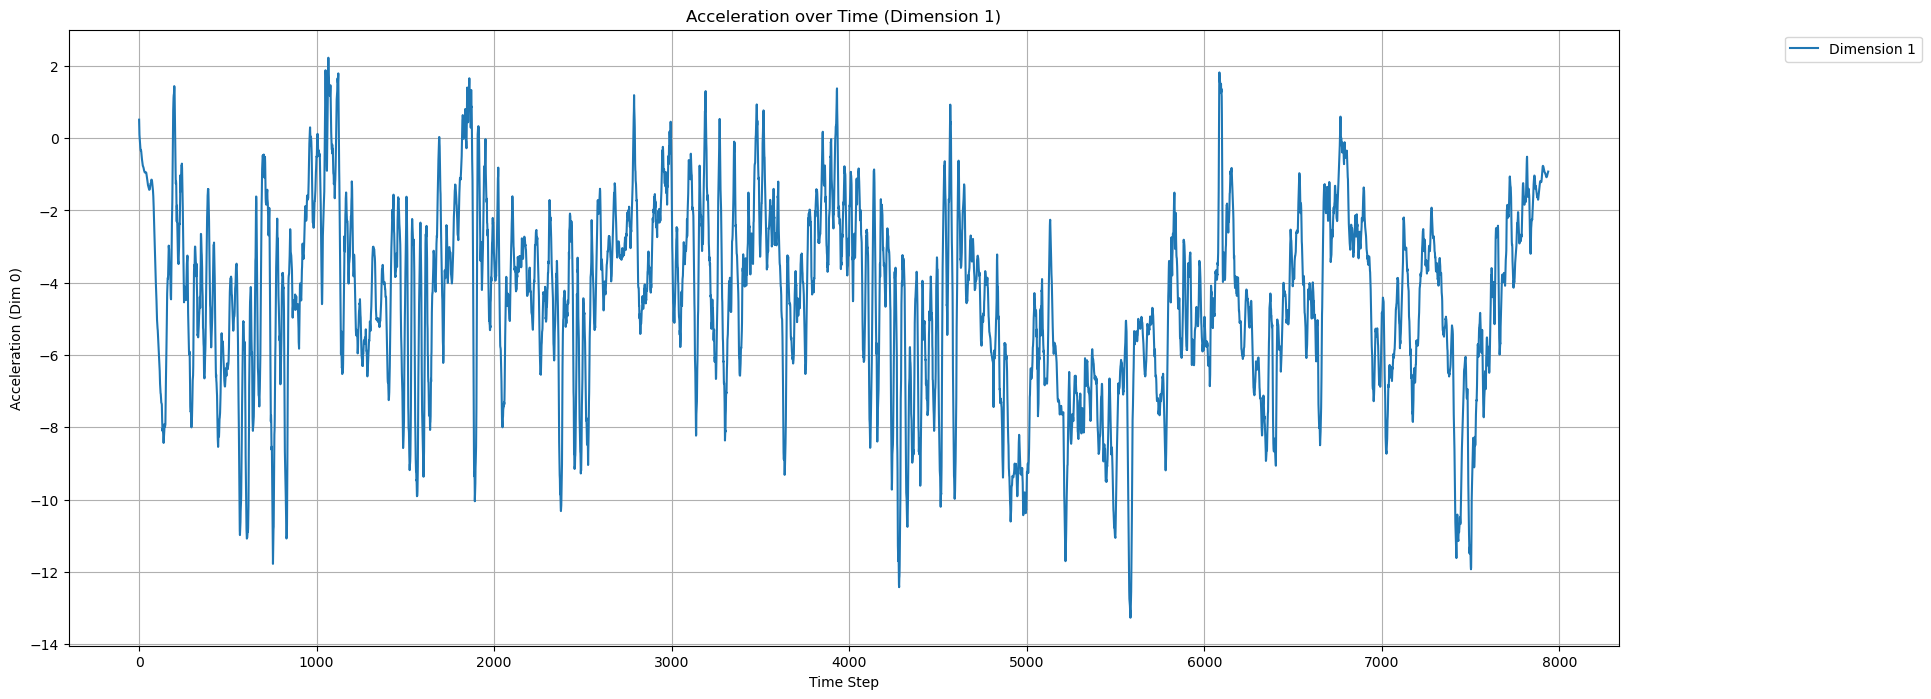

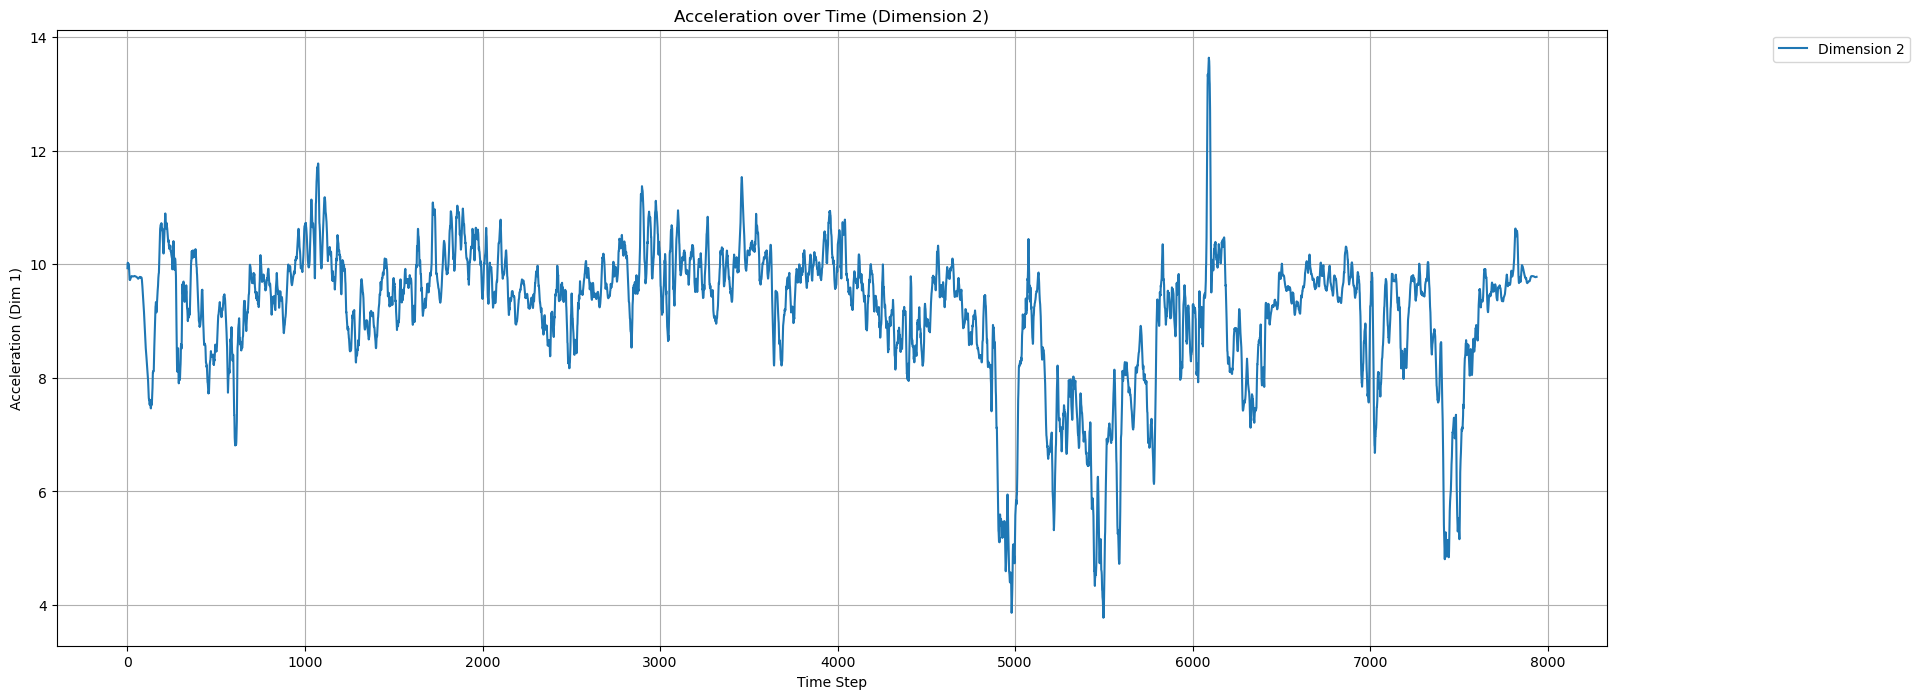

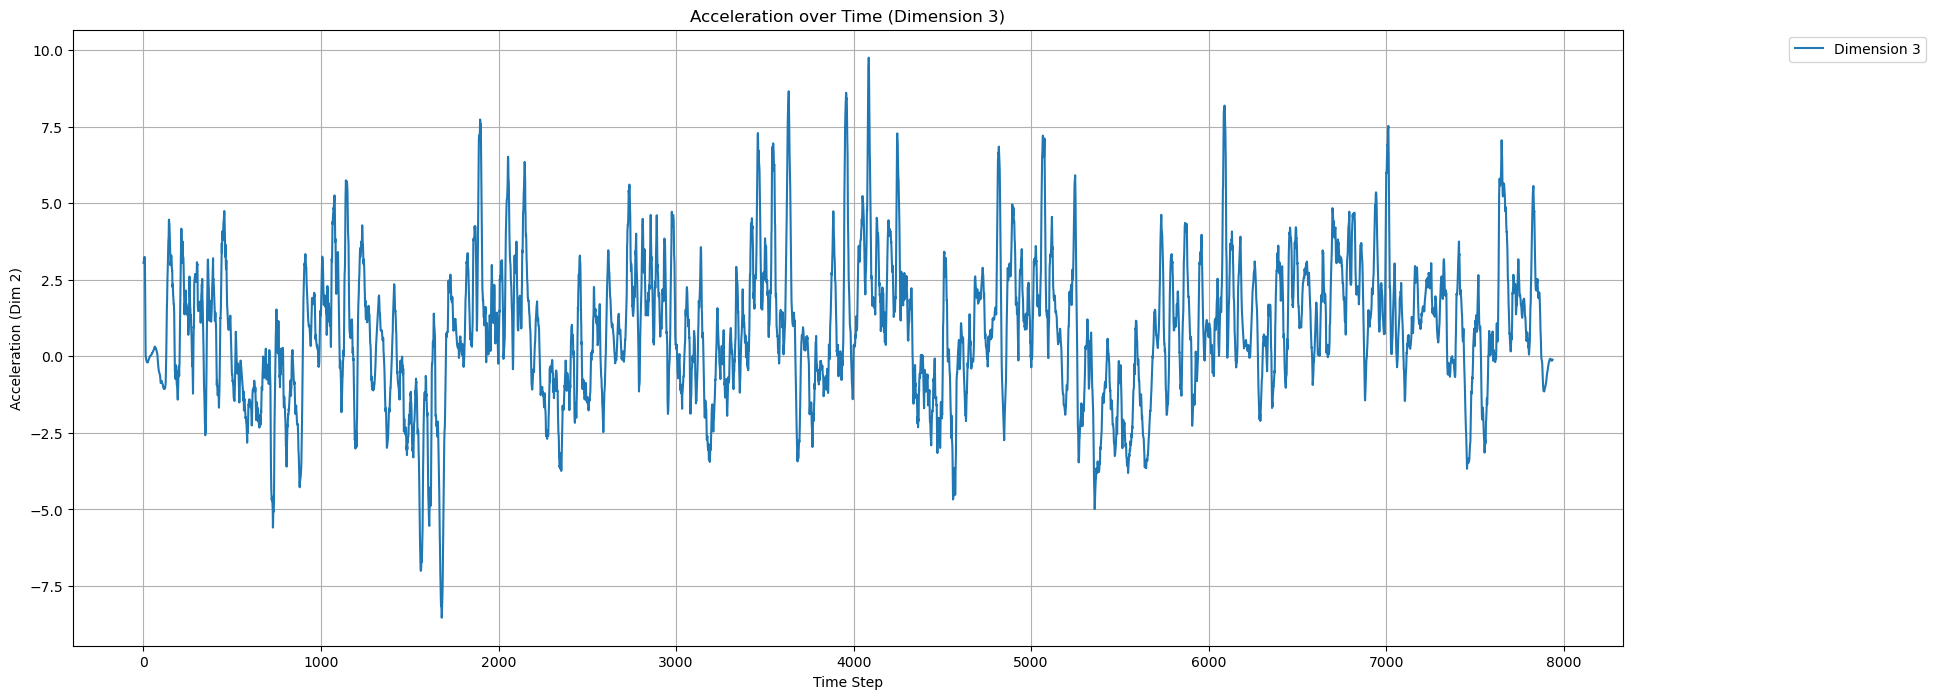

In [11]:
dip_subject = DIP_Subject(trial_path)

In [12]:
import pickle
with open("/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/DIP_orig/S1/01.pkl", "rb") as file:
    loaded_dict = pickle.load(file, encoding="latin1")

loaded_dict.keys()

dict_keys(['gt', 'imu_acc', 'sop', 'sip', 'imu', 'imu_ori'])

In [13]:
loaded_dict['gt'].shape

(13778, 72)

In [14]:
loaded_dict["imu"].shape

(13778, 17, 12)

In [15]:
loaded_dict["imu_acc"].shape

(13778, 17, 3)